In [1]:
!pip install networkx numpy pandas matplotlib seaborn qiskit qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.6 MB/s eta 0:00:00


Simulating DTQW on 8-cycle up to 10 steps...
   Simulating step 0/10...
   Step 0 finished in 0.52s (Cumulative: 0.52s)

--- DEBUG: SIMULATING FOR t = 1 ---

DEBUG: CREATING DTQW CIRCUIT FOR steps = 1
DEBUG: Circuit for steps = 1 (text drawing):
           Init       ░ ┌───────┐ ░                                                                                     ░ ┌──────┐ ░  Step 1 ┌─┐      
q_0: ───────░─────────░─┤0      ├─░──■─────────────■────────────────────────────────────────────────────────────────────░─┤0     ├─░────░────┤M├──────
            ░         ░ │       │ ░  │             │                                                                    ░ │      │ ░    ░    └╥┘┌─┐   
q_1: ───────░─────────░─┤1 IQFT ├─░──┼─────────────┼──────────────■─────────────■───────────────────────────────────────░─┤1 QFT ├─░────░─────╫─┤M├───
            ░         ░ │       │ ░  │             │              │             │                                       ░ │      │ ░    ░     ║ └╥┘┌─┐

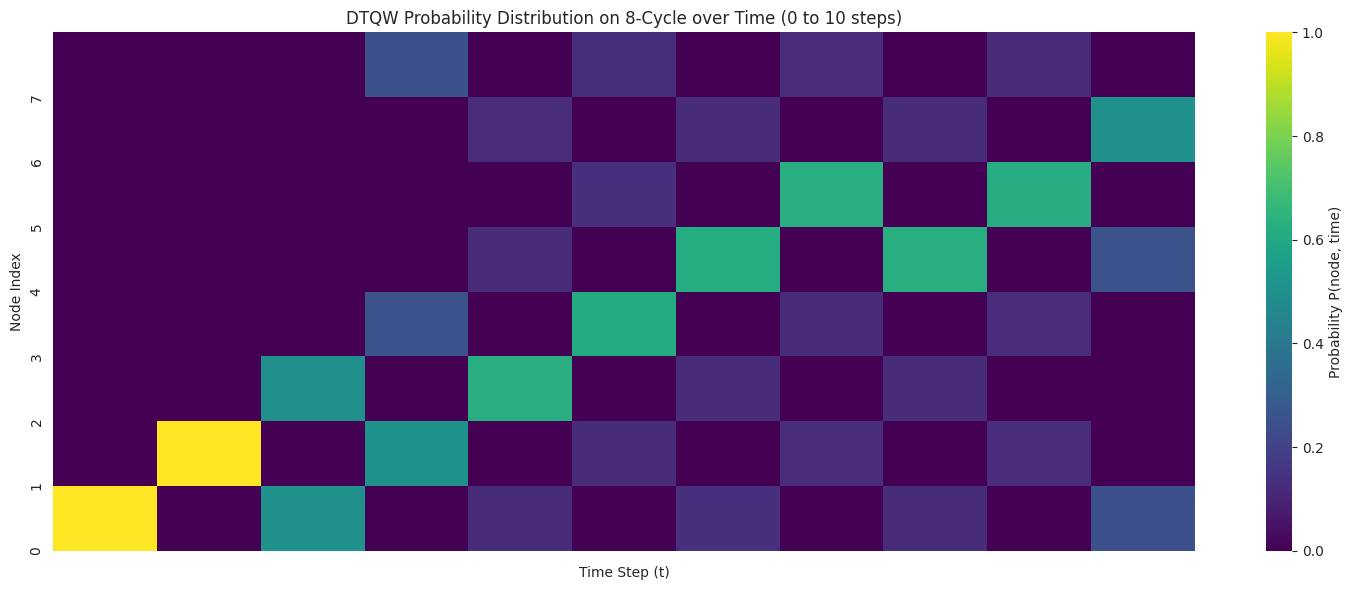

DEBUG: Data for snapshot plot at t_step=1 (probs): [0. 1. 0. 0. 0. 0. 0. 0.]
DEBUG: Sum of probs for snapshot t_step=1: 1.0000


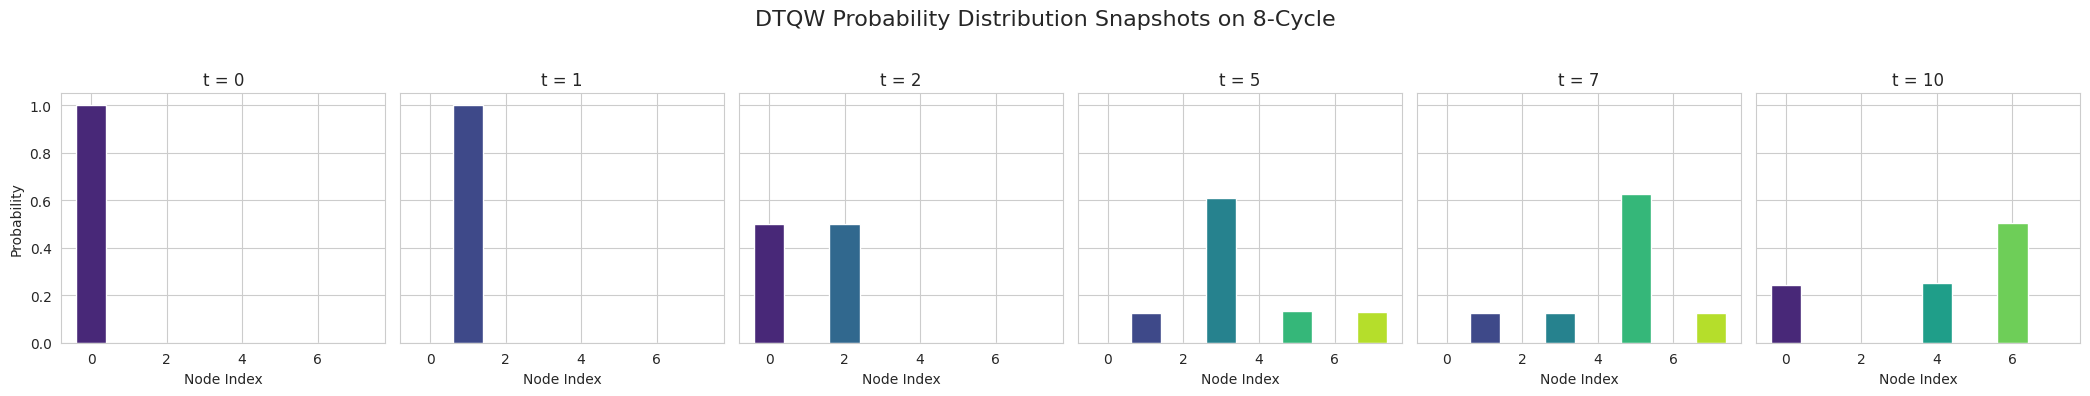

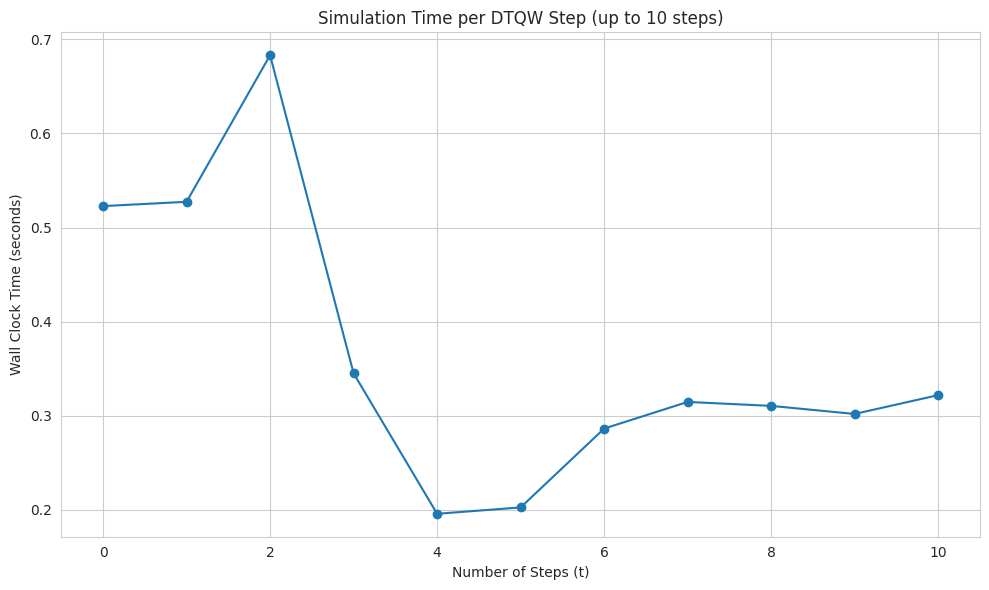

DEBUG: Length of all_probabilities for averaging: 11
DEBUG: Calculated avg_probs: [0.11260986 0.18803711 0.13707275 0.11132812 0.16252441 0.13811035
 0.08779297 0.06252441]
DEBUG: Sum of avg_probs: 1.0000


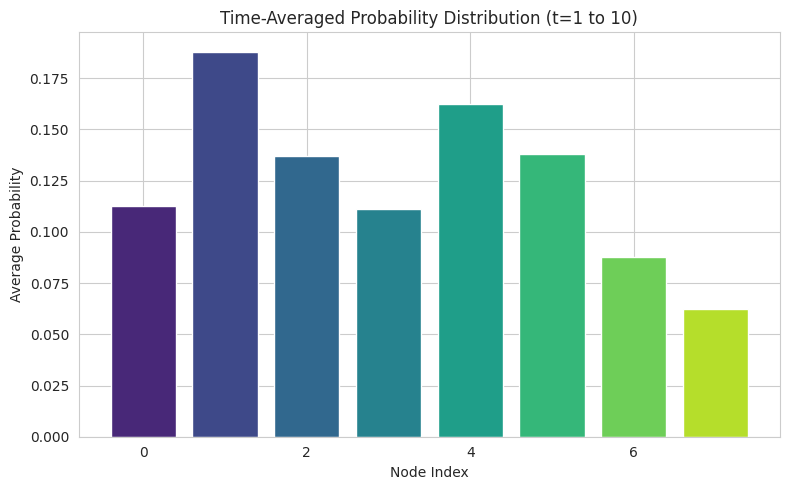

In [3]:
# -*- coding: utf-8 -*-
"""
Simulates a Discrete-Time Quantum Walk (DTQW) on an 8-cycle graph
for 100 steps using Qiskit and visualizes the probability distribution
over time, including the time-averaged distribution.
Uses a Hadamard coin and QFT-based shift operator.
"""

import networkx as nx
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Qiskit Imports ---
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator # Use AerSimulator
from qiskit.circuit.library import QFT, PhaseGate
from qiskit.visualization import plot_histogram

# --- Configuration ---
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- Helper Functions ---

def add_qft_arithmetic_shift(circuit, qr_pos, coin_qubit):
    """
    Applies a conditional shift (+1 if coin=1, -1 if coin=0)
    on position qubits using QFT-based phase additions.
    """
    n_pos = len(qr_pos)
    # Apply Inverse QFT
    iqft_gate = QFT(n_pos, do_swaps=False, inverse=True, name="IQFT").to_gate()
    circuit.append(iqft_gate, qr_pos)
    circuit.barrier()
    # Apply controlled phase shifts
    for k in range(n_pos):
        angle = 2 * np.pi / (2**(n_pos - k))
        circuit.cp(angle, coin_qubit, qr_pos[k]) # Increment for |1> coin
        circuit.x(coin_qubit)
        circuit.cp(-angle, coin_qubit, qr_pos[k]) # Decrement for |0> coin
        circuit.x(coin_qubit)
    circuit.barrier()
    # Apply QFT
    qft_gate = QFT(n_pos, do_swaps=False, inverse=False, name="QFT").to_gate()
    circuit.append(qft_gate, qr_pos)
    circuit.barrier()


def create_dtqw_circuit_cycle(n_pos_qubits, steps):
    """
    Creates a Qiskit circuit for a DTQW on a 2^n_pos_qubits cycle
    with Hadamard coin and QFT-based shift.
    """
    n_total_qubits = n_pos_qubits + 1
    coin_qubit = n_pos_qubits

    qr = QuantumRegister(n_total_qubits, 'q')
    cr = ClassicalRegister(n_pos_qubits, 'c')
    qc = QuantumCircuit(qr, cr, name="DTQW_Cycle")

    # DEBUG: Print when creating circuit for steps=1
    if steps == 1:
        print(f"\nDEBUG: CREATING DTQW CIRCUIT FOR steps = 1")

    # Build one step
    def add_dtqw_step(circuit):
        circuit.h(coin_qubit)
        circuit.barrier()
        add_qft_arithmetic_shift(circuit, qr[0:n_pos_qubits], coin_qubit)

    # Construct Full Circuit
    # Initial State: Coin |+>, Position |0...0>
    qc.h(coin_qubit)
    qc.barrier(label="Init")

    # Apply DTQW steps
    for step_num in range(steps):
        add_dtqw_step(qc)
        if (step_num + 1) % 10 == 0 or steps < 20:
            qc.barrier(label=f"Step {step_num+1}")
    if steps > 0 and (steps % 10 != 0 and steps >= 20): # Ensure final barrier if needed and steps > 0
         qc.barrier(label=f"Step {steps}")


    # Measurement
    qc.measure(qr[0:n_pos_qubits], cr)

    # DEBUG: Draw circuit for steps=1
    if steps == 1:
        print("DEBUG: Circuit for steps = 1 (text drawing):")
        try:
            print(qc.draw(output='text', fold=-1)) # fold=-1 to prevent wrapping
        except Exception as e:
            print(f"DEBUG: Could not draw circuit: {e}")
        print(f"DEBUG: Circuit depth for steps=1: {qc.depth()}")
        print(f"DEBUG: Circuit size for steps=1: {qc.size()}")
        print(f"DEBUG: Circuit num_qubits for steps=1: {qc.num_qubits}")
        print(f"DEBUG: Circuit num_clbits for steps=1: {qc.num_clbits}")


    return qc

def run_qiskit_simulation(qc, shots=4096):
    """Runs the Qiskit circuit on AerSimulator."""
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return counts

def get_probabilities_from_counts(counts, N, n_pos_qubits, shots, current_step_t=-1): # Added current_step_t for debug
    """Converts Qiskit counts dictionary to a probability array."""
    node_probs = np.zeros(N)
    # DEBUG: Print counts if current_step_t is 1
    if current_step_t == 1:
        print(f"DEBUG (get_probabilities_from_counts, t=1): Raw counts received: {counts}")

    for bitstring, count in counts.items():
        node_idx = int(bitstring[::-1], 2) # Qiskit's bitstring is little-endian for registers
        if node_idx < N:
            node_probs[node_idx] += count / shots
        # DEBUG: Print bitstring processing if current_step_t is 1
        if current_step_t == 1:
            print(f"DEBUG (get_probabilities_from_counts, t=1): bitstring='{bitstring}', reversed='{bitstring[::-1]}', node_idx={node_idx}, count={count}, prob_contrib={count/shots:.4f}")

    # DEBUG: Print final node_probs if current_step_t is 1
    if current_step_t == 1:
        print(f"DEBUG (get_probabilities_from_counts, t=1): Calculated node_probs: {node_probs}")
        print(f"DEBUG (get_probabilities_from_counts, t=1): Sum of node_probs: {np.sum(node_probs):.4f}")
    return node_probs

# ========== Main Experiment ==========
start_time_global = time.time()

# --- Parameters ---
N_cycle = 8
n_pos_qubits = int(np.ceil(np.log2(N_cycle)))
if 2**n_pos_qubits != N_cycle:
    raise ValueError(f"N_cycle must be a power of 2. Got {N_cycle}")

max_steps = 10 # DEBUG: Reduce max_steps for quicker debugging runs
# max_steps = 100
shots_per_step = 4096 * 2 # DEBUG: Increase shots for potentially cleaner probabilities at t=1

# --- Simulate Step-by-Step ---
print(f"Simulating DTQW on {N_cycle}-cycle up to {max_steps} steps...")
all_probabilities = []
simulation_times = []

for t in range(max_steps + 1):
    step_start_time = time.time()
    # DEBUG: Clearer print for simulation step
    if t == 1:
        print(f"\n--- DEBUG: SIMULATING FOR t = 1 ---")
    else:
        print(f"   Simulating step {t}/{max_steps}...")


    qc_t = create_dtqw_circuit_cycle(n_pos_qubits, steps=t)
    counts_t = run_qiskit_simulation(qc_t, shots=shots_per_step)
    # Pass 't' to the function for conditional debugging prints
    probs_t = get_probabilities_from_counts(counts_t, N_cycle, n_pos_qubits, shots_per_step, current_step_t=t)
    all_probabilities.append(probs_t)
    step_time = time.time() - step_start_time
    simulation_times.append(step_time)

    if t == 1:
        print(f"--- DEBUG: FINISHED SIMULATION FOR t = 1 ---")
        print(f"DEBUG: all_probabilities[1] after append: {all_probabilities[1]}\n")


    if t % 10 == 0 or t == max_steps:
        print(f"   Step {t} finished in {step_time:.2f}s (Cumulative: {(time.time() - start_time_global):.2f}s)")


print(f"\nSimulation finished in {(time.time() - start_time_global) / 60:.2f} minutes.")

# DEBUG: Print all_probabilities[0] and all_probabilities[1] before plotting
if len(all_probabilities) > 1:
    print(f"\nDEBUG: Before plotting, all_probabilities[0]: {all_probabilities[0]}")
    print(f"DEBUG: Before plotting, sum(all_probabilities[0]): {np.sum(all_probabilities[0]):.4f}")
    print(f"DEBUG: Before plotting, all_probabilities[1]: {all_probabilities[1]}")
    print(f"DEBUG: Before plotting, sum(all_probabilities[1]): {np.sum(all_probabilities[1]):.4f}")
else:
    print("\nDEBUG: Not enough steps to print all_probabilities[0] and [1].")


# --- Visualization ---
print("\n--- Plotting Results ---")
sns.set_style("whitegrid")

# 1. Heatmap
plt.figure(figsize=(15, 6))
prob_matrix = np.array(all_probabilities).T
# DEBUG: Print shape of prob_matrix
print(f"DEBUG: Shape of prob_matrix for heatmap: {prob_matrix.shape}")
if prob_matrix.shape[1] > 1:
    print(f"DEBUG: Data for heatmap t=1 (prob_matrix[:, 1]): {prob_matrix[:, 1]}")

sns.heatmap(prob_matrix, cmap="viridis", cbar_kws={'label': 'Probability P(node, time)'})
plt.title(f'DTQW Probability Distribution on {N_cycle}-Cycle over Time (0 to {max_steps} steps)')
plt.xlabel('Time Step (t)')
plt.ylabel('Node Index')
plt.xticks(np.arange(0, max_steps + 1, step=max(1, max_steps // 10)))
plt.yticks(np.arange(0, N_cycle, step=1), labels=np.arange(0, N_cycle, step=1))
plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig(f"dtqw_{N_cycle}cycle_heatmap_{max_steps}steps_DEBUG.png", dpi=300)
# print(f"Saved probability heatmap to dtqw_{N_cycle}cycle_heatmap_{max_steps}steps_DEBUG.png")
plt.show()

# 2. Bar plots for selected time steps
selected_steps = [0, 1, 5, max_steps // 4, max_steps // 2, 3 * max_steps // 4, max_steps]
selected_steps = sorted(list(set(s for s in selected_steps if s <= max_steps))) # Ensure steps are valid and sorted

if selected_steps: # only plot if there are steps to select
    n_plots = len(selected_steps)
    fig, axes = plt.subplots(1, n_plots, figsize=(3.5 * n_plots, 4), sharey=True)
    if n_plots == 1: axes = [axes] # Make axes iterable if only one plot
    fig.suptitle(f'DTQW Probability Distribution Snapshots on {N_cycle}-Cycle', fontsize=16)
    for i, t_step in enumerate(selected_steps):
        if t_step < len(all_probabilities):
            ax = axes[i]
            probs = all_probabilities[t_step]
            # DEBUG: Print probs for snapshot t_step=1
            if t_step == 1:
                print(f"DEBUG: Data for snapshot plot at t_step=1 (probs): {probs}")
                print(f"DEBUG: Sum of probs for snapshot t_step=1: {np.sum(probs):.4f}")

            nodes = np.arange(N_cycle)
            ax.bar(nodes, probs, color=sns.color_palette('viridis', N_cycle))
            ax.set_title(f't = {t_step}')
            ax.set_xlabel('Node Index')
            if i == 0: ax.set_ylabel('Probability')
            ax.set_xticks(nodes[::max(1, N_cycle // 4)])
            ax.set_ylim(0, 1.05) # Adjusted ylim slightly
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f"dtqw_{N_cycle}cycle_snapshots_{max_steps}steps_DEBUG.png", dpi=300)
    # print(f"Saved probability snapshots to dtqw_{N_cycle}cycle_snapshots_{max_steps}steps_DEBUG.png")
    plt.show()
else:
    print("DEBUG: No selected steps to plot for snapshots (max_steps might be too low).")


# 3. Plot Simulation Time per Step
plt.figure(figsize=(10, 6))
plt.plot(range(max_steps + 1), simulation_times, marker='o', linestyle='-')
plt.title(f'Simulation Time per DTQW Step (up to {max_steps} steps)')
plt.xlabel('Number of Steps (t)')
plt.ylabel('Wall Clock Time (seconds)')
plt.grid(True)
plt.tight_layout()
# plt.savefig(f"dtqw_{N_cycle}cycle_runtime_{max_steps}steps_DEBUG.png", dpi=300)
# print(f"Saved runtime plot to dtqw_{N_cycle}cycle_runtime_{max_steps}steps_DEBUG.png")
plt.show()

# 4. Plot Time-Averaged Probability Distribution
if max_steps > 0 and len(all_probabilities) > 1 : # Ensure there's data to average
    plt.figure(figsize=(8, 5))
    # DEBUG: Check content of all_probabilities before averaging
    print(f"DEBUG: Length of all_probabilities for averaging: {len(all_probabilities)}")
    # print(f"DEBUG: all_probabilities[1:] for averaging: {all_probabilities[1:]}")

    avg_probs = np.mean(all_probabilities[1:], axis=0)
    # DEBUG: Print avg_probs
    print(f"DEBUG: Calculated avg_probs: {avg_probs}")
    print(f"DEBUG: Sum of avg_probs: {np.sum(avg_probs):.4f}")

    nodes = np.arange(N_cycle)
    plt.bar(nodes, avg_probs, color=sns.color_palette('viridis', N_cycle))
    plt.title(f'Time-Averaged Probability Distribution (t=1 to {max_steps})')
    plt.xlabel('Node Index')
    plt.ylabel('Average Probability')
    plt.xticks(nodes[::max(1, N_cycle // 4)])
    plt.tight_layout()
    # plt.savefig(f"dtqw_{N_cycle}cycle_avg_prob_{max_steps}steps_DEBUG.png", dpi=300)
    # print(f"Saved time-averaged probability plot to dtqw_{N_cycle}cycle_avg_prob_{max_steps}steps_DEBUG.png")
    plt.show()
else:
    print("DEBUG: Not plotting time-averaged distribution (max_steps=0 or not enough data).")